In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torchvision import models
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
from collections import defaultdict
import time
import numpy as np
import pandas as pd

In [2]:
BATCH_SIZE = 128

data_dir_train = '/kaggle/input/classification-of-butterflies/train_butterflies/train_split'
data_dir_test = '/kaggle/input/classification-of-butterflies/test_butterflies'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir_train, transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
model_resnet34 = models.resnet34(pretrained=False)
model_resnet34.fc = nn.Linear(model_resnet34.fc.in_features, 50)
model_resnet34 = model_resnet34.to(device)

In [8]:
model_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))
    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [10]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        model.train(True)
        model.to(device)

        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        scheduler.step()

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        model.train(False)
        
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

Epoch 12 of 12 took 23.448s
  training loss (in-iteration): 	0.839471
  validation loss (in-iteration): 	1.040343
  training accuracy: 			75.03 %
  validation accuracy: 			69.03 %


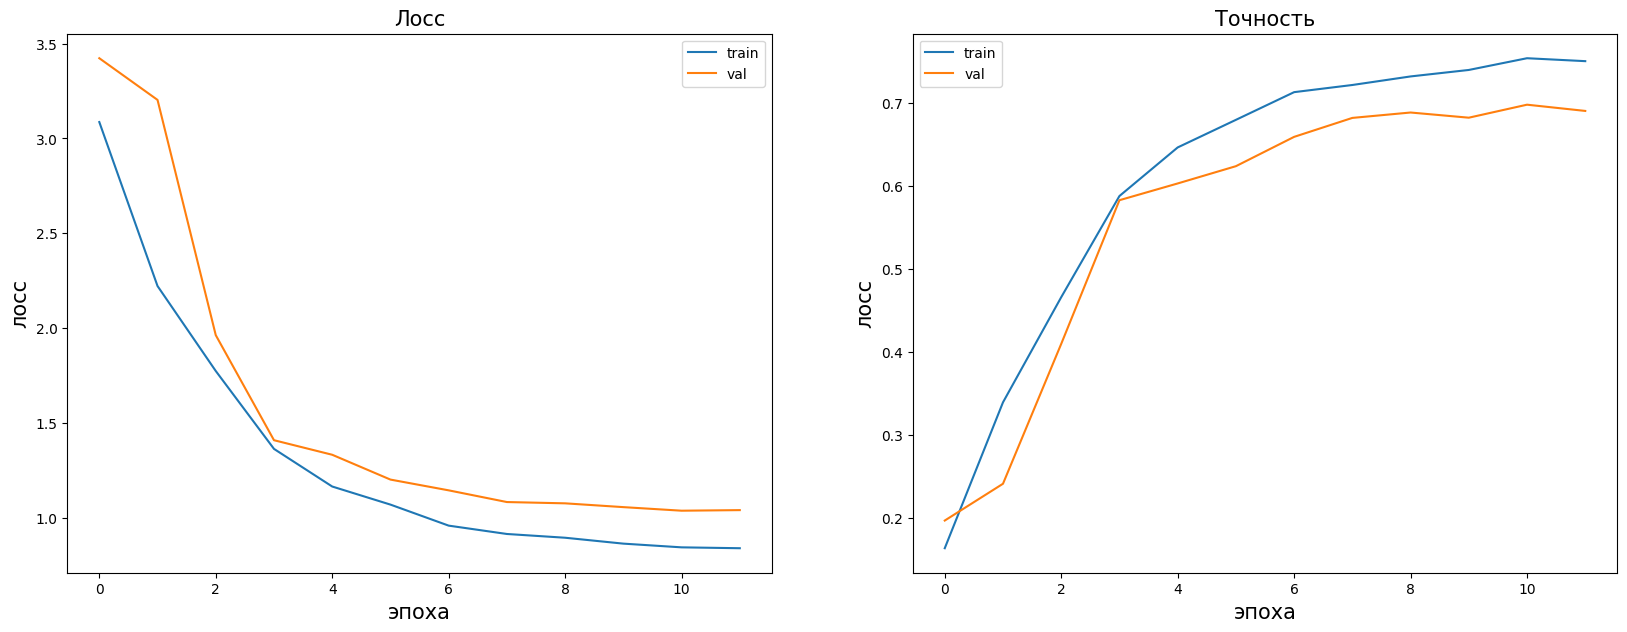

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet34.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

clf_model, history = train(
    model_resnet34, criterion, optimizer,
    scheduler, train_loader, valid_loader,
    num_epochs=12
)

In [13]:

test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform)

sample_name = [path.split('/')[-1].split('.')[0] for path, _ in test_dataset.samples]

data_pred = []
for data, _ in test_dataset:
    data_pred.append(data.clone().detach())

data_pred = torch.stack(data_pred, dim=0)
data_pred = data_pred.to(device)
pred = clf_model(data_pred)

str_nums = sorted([str(i) for i in range(50)])

to_real_index = {i : int(str_nums[i]) for i in range(50)}

res = [to_real_index[torch.argmax(item).item()] for item in pred]

cnt_output = len(res)

output = {
    "index": sample_name,
    "label": res,
}

output = pd.DataFrame(output)

output.to_csv('submission.csv', index=False)